In [1]:
import os 
import django

os.environ['DJANGO_ALLOW_ASYNC_UNSAFE'] = 'true'
django.setup()

In [6]:
from datetime import datetime, date, timedelta
from bourse_refs_api.models import StockHistory, Stock
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### Fixed Inputs 

In [138]:
# These two date are given just for collecting the dataset in "stock_histories_repo" !
start_date = '2017-08-01'
end_date = '2020-02-01'

# Maximum % of increasment in price that we are OK with !
price_thres = 5

# Window size for calculating volume fraction in days
window_size = 10

# Threshold value for volume fraction in %
base_vol_frac = 20

# Saving executed orders
exe_orders = {'Date':[], 'Size':[], 'Type':[], 'Adjusted Price':[]}

#### Dynamic Inputs

In [139]:
# Inputs from the algorithm !
stock_name = 'شلعاب'
order_size = 10000000
order_type = 'buy'
order_time = '2018-12-30'

## Importing Dataset

In [4]:
START_DATE = datetime.strptime(start_date, "%Y-%m-%d")
END_DATE = datetime.strptime(end_date, "%Y-%m-%d")

START = date(int(start_date.split('-')[0]),int(start_date.split('-')[1]),int(start_date.split('-')[2]))
END = date(int(end_date.split('-')[0]),int(end_date.split('-')[1]),int(end_date.split('-')[2]))

In [5]:
available_stocks = list(Stock.objects.filter(
    stockhistory__date__gte=START_DATE,
    stockhistory__date__lte=END_DATE
).distinct())

stock_histories_repo = {}
for stock in tqdm(available_stocks, desc="Creating repository"):
    stock_histories = list(StockHistory.objects.filter(
        stock=stock,
        date__gte=START_DATE,
        date__lte=END_DATE
    ))
    stock_histories_repo[stock.name] = {}
    for stock_history in stock_histories:
        stock_histories_repo[stock.name][stock_history.date] = stock_history

Creating repository:   0%|          | 0/834 [00:00<?, ?it/s]

## Order Slicing using modified VWAP

#### Buying 

In [140]:
if order_type == 'buy':
    
    # Buying one slice of order
    def buy_slice(order_size, vol_frac, Date, price):
        exe_orders['Date'].append(Date)
        exe_orders['Size'].append(vol_frac*order_size)
        exe_orders['Adjusted Price'].append(price)
        exe_orders['Type'].append('buy')

        # Calculate the bought size
        bought_size = vol_frac*order_size

        # Calculate new remained_share to buy in future
        order_size -= bought_size

        return bought_size, order_size

    order_Date = date(int(order_time.split('-')[0]),int(order_time.split('-')[1]),int(order_time.split('-')[2]))
    Date = order_Date

    # Saving the price of share at the time of order arrival
    base_adj_price = (stock_histories_repo[stock_name][Date].max_price + stock_histories_repo[stock_name][Date].min_price +
                     stock_histories_repo[stock_name][Date].last_price + stock_histories_repo[stock_name][Date].first_price)/4

    # Total shares of buy after slicing (might not be always equal to the algorithm order_size ! since we have a trigering
    # price threshold)
    total_bought_share = 0

    # Do while until either our order is fully filled or the openning price is above the determined threshold
    while ((order_size > 0) and (stock_histories_repo[stock_name][Date].first_price < (1+price_thres/100)*base_adj_price)):
        stock_data = stock_histories_repo[stock_name][Date]

        # Calculating fraction of order day volume to the past window_size (eg. 10) days volume !
        total_vol = 0
        time = Date
        for i in range(window_size):
            time -= timedelta(days = i)
            if time in stock_histories_repo[stock_name]:
                total_vol += stock_histories_repo[stock_name][time].volume

        vol_frac = stock_data.volume/total_vol

        # Calculating the adjusted price
        adj_price = (stock_data.max_price + stock_data.min_price + stock_data.last_price + stock_data.first_price)/4

        # We dont want to overestimate the vol_frac value, so we adjust it !
        if vol_frac > base_vol_frac/100:
            vol_frac = base_vol_frac/100

        # If our buy value is less than vol_frac (eg. 10%) of the volume of the order date, then we buy all at once
        if (order_size < vol_frac*stock_data.volume):
            exe_orders['Date'].append(Date)
            exe_orders['Size'].append(order_size)
            exe_orders['Adjusted Price'].append(adj_price)
            exe_orders['Type'].append('buy')

            total_bought_share += order_size

            # We are done
            order_size = 0

        # Otherwise, we must slice the big order. (buy vol_frac of shares)
        else:
            bought_size, order_size = buy_slice(order_size, vol_frac, Date, adj_price)
            total_bought_share += bought_size

        # We dont have always next day in dataset. So must go day by day until we have it !
        while True:
            Date += timedelta(days = 1)
            if Date in stock_histories_repo[stock_name]:
                break

        print('Vol_frac = ', vol_frac)  
        print('Volume = ', stock_data.volume)
        print('Date = ', Date)
        print('order_size = ', order_size)
        print('order_type= ', 'buy')
        print('Adjusted Price = ', stock_data.first_price)
        print('total_bought_share = ', total_bought_share)
        print('-------------------------------------------------')

    print('###########################')
    avg_price = np.dot(exe_orders['Size'],exe_orders['Adjusted Price'])/sum(exe_orders['Size'])
    print('Total {} shares of {} bought at average price of {}'.format(round(total_bought_share, 3), stock_name, 
                                                                       round(avg_price,3)))

Vol_frac =  0.09194605931734835
Volume =  253607
Date =  2018-12-31
order_size =  9080539.406826517
order_type=  buy
Adjusted Price =  2430
total_bought_share =  919460.5931734835
-------------------------------------------------
Vol_frac =  0.13151196977038915
Volume =  225805
Date =  2019-01-01
order_size =  7886339.78285712
order_type=  buy
Adjusted Price =  2324
total_bought_share =  2113660.21714288
-------------------------------------------------
Vol_frac =  0.07497375426396473
Volume =  363289
Date =  2019-01-02
order_size =  7295071.281935061
order_type=  buy
Adjusted Price =  2350
total_bought_share =  2704928.7180649387
-------------------------------------------------
Vol_frac =  0.11336618150226871
Volume =  444977
Date =  2019-01-05
order_size =  6468056.906915223
order_type=  buy
Adjusted Price =  2408
total_bought_share =  3531943.093084777
-------------------------------------------------
Vol_frac =  0.09511793212898048
Volume =  250288
Date =  2019-01-06
order_size = 

#### Selling

In [18]:
if order_type == 'sell':
    
    # selling one slice of order
    def sell_slice(order_size, vol_frac, Date, price):
        exe_orders['Date'].append(Date)
        exe_orders['Size'].append(vol_frac*order_size)
        exe_orders['Adjusted Price'].append(price)
        exe_orders['Type'].append('sell')

        # Calculate the sold size
        sell_size = vol_frac*order_size

        # Calculate new remained_share to sell in future
        order_size -= sell_size

        return sell_size, order_size

    order_Date = date(int(order_time.split('-')[0]),int(order_time.split('-')[1]),int(order_time.split('-')[2]))
    Date = order_Date

    # Saving the price of share at the time of order arrival
    base_adj_price = (stock_histories_repo[stock_name][Date].max_price + stock_histories_repo[stock_name][Date].min_price +
                     stock_histories_repo[stock_name][Date].last_price + stock_histories_repo[stock_name][Date].first_price)/4

    # Total shares of sell after slicing (might not be always equal to the algorithm order_size ! since we have a trigering
    # price threshold)
    total_sell_share = 0

    # Do while until either our order is fully filled or the openning price is above the determined threshold
    while ((order_size > 0) and (stock_histories_repo[stock_name][Date].first_price < (1+price_thres/100)*base_adj_price)):
        stock_data = stock_histories_repo[stock_name][Date]

        # Calculating fraction of order day volume to the past window_size (eg. 10) days volume !
        total_vol = 0
        time = Date
        for i in range(window_size):
            time -= timedelta(days = i)
            if time in stock_histories_repo[stock_name]:
                total_vol += stock_histories_repo[stock_name][time].volume

        vol_frac = stock_data.volume/total_vol

        # Calculating the adjusted price
        adj_price = (stock_data.max_price + stock_data.min_price + stock_data.last_price + stock_data.first_price)/4

        # We dont want to overestimate the vol_frac value, so we adjust it !
        if vol_frac > base_vol_frac/100:
            vol_frac = base_vol_frac/100

        # If our sell value is less than vol_frac (eg. 10%) of the volume of the order date, then we sell all at once
        if (order_size < vol_frac*stock_data.volume):
            exe_orders['Date'].append(Date)
            exe_orders['Size'].append(order_size)
            exe_orders['Adjusted Price'].append(adj_price)
            exe_orders['Type'].append('sell')

            total_sell_share += order_size

            # We are done
            order_size = 0

        # Otherwise, we must slice the big order. (sell vol_frac of shares)
        else:
            sell_size, order_size = sell_slice(order_size, vol_frac, Date, adj_price)
            total_sell_share += sell_size

        # We dont have always next day in dataset. So must go day by day until we have it !
        while True:
            Date += timedelta(days = 1)
            if Date in stock_histories_repo[stock_name]:
                break

        print('Vol_frac = ', vol_frac)  
        print('Volume = ', stock_data.volume)
        print('Date = ', Date)
        print('order_size = ', order_size)
        print('order_type = ', 'sell')
        print('Adjusted Price = ', stock_data.first_price)
        print('total_sell_share = ', total_sell_share)
        print('-------------------------------------------------')

    print('###########################')
    avg_price = np.dot(exe_orders['Size'],exe_orders['Adjusted Price'])/sum(exe_orders['Size'])
    print('Total {} shares of {} sold at average price of {}'.format(round(total_sell_share, 3), stock_name, 
                                                                       round(avg_price,3)))

Vol_frac =  0.09746827302948882
Volume =  13595634
Date =  2018-12-31
order_size =  9025317.269705111
order_type =  sell
Adjusted Price =  4921
total_sell_share =  974682.7302948883
-------------------------------------------------
Vol_frac =  0.1366359947395032
Volume =  13372959
Date =  2019-01-01
order_size =  7792134.066719336
order_type =  sell
Adjusted Price =  4915
total_sell_share =  2207865.933280663
-------------------------------------------------
Vol_frac =  0.04084389421554005
Volume =  11009272
Date =  2019-01-02
order_size =  7473872.967184946
order_type =  sell
Adjusted Price =  4889
total_sell_share =  2526127.0328150536
-------------------------------------------------
Vol_frac =  0.10227733452498623
Volume =  19906632
Date =  2019-01-05
order_size =  6709465.161522919
order_type =  sell
Adjusted Price =  4715
total_sell_share =  3290534.8384770798
-------------------------------------------------
Vol_frac =  0.0792669143071621
Volume =  9196638
Date =  2019-01-06
ord

### Results in table

In [141]:
sliced_orders = pd.DataFrame(data = exe_orders)
sliced_orders

,Date,Size,Type,Adjusted Price
0,2018-12-30,9.194606e+05,buy,2382.00
1,2018-12-31,1.194200e+06,buy,2344.75
2,2019-01-01,5.912685e+05,buy,2369.00
3,2019-01-02,8.270144e+05,buy,2412.00
4,2019-01-05,6.152282e+05,buy,2414.50
5,2019-01-06,5.604011e+05,buy,2385.00
6,2019-01-07,1.004069e+06,buy,2326.00
7,2019-01-08,2.326677e+05,buy,2340.75
8,2019-01-09,8.111381e+05,buy,2425.50
9,2019-01-12,6.489105e+05,buy,2525.00


### Visualization

In [145]:
def plot_stock(stock_name, start = START, end = END, order_hist = exe_orders):
    data_frame = {'Date':[], 'Open':[], 'Close':[], 'High':[], 'Low':[], 'Volume':[]}
    
    delta = end - start  
    
    for i in range(delta.days + 1):  
        day = start + timedelta(days=i)
        
        # if we have the day in the database
        if day in stock_histories_repo[stock_name]:
            data_frame['Date'].append(day)
            data_frame['Open'].append(stock_histories_repo[stock_name][day].first_price)
            data_frame['Close'].append(stock_histories_repo[stock_name][day].last_price)
            data_frame['High'].append(stock_histories_repo[stock_name][day].max_price)
            data_frame['Low'].append(stock_histories_repo[stock_name][day].min_price)
            data_frame['Volume'].append(stock_histories_repo[stock_name][day].volume)
    
    df = pd.DataFrame(data=data_frame)
    
    plt.plot(df['Date'], df['Close'], label = 'Stock Price')
    plt.xticks(rotation=45)
    
    for i in range(len(exe_orders['Date'])):
        x = exe_orders['Date'][i]
        y = float(df[df['Date'] == x]['Close'])
        plt.arrow(x, 0.99*y, 0, 0.004*y, width = 0.1, head_width = 0.4, head_length = 0.005*y, ec ='green')
        
    plt.axhline(y = avg_price, color='red', linestyle='dotted', label = "Average Executed Price")
    
    plt.legend()
    

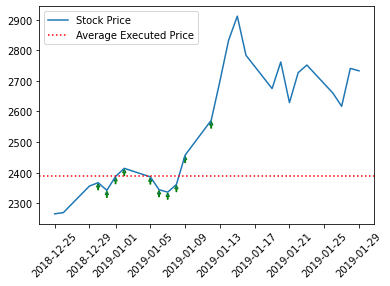

In [146]:
plot_stock(stock_name, order_Date - timedelta(days=5), order_Date + timedelta(days=30))